In [1]:
# ! pip install shap

In [2]:
import pandas as pd
import shap
import shap.explainers._kernel as kernel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split as tts

%matplotlib notebook

In [3]:
# Load and split data
data = pd.read_csv("Thyroid_Diff.csv")
X = data.drop("Recurred", axis=1)
y = data["Recurred"].map({"No": 0, "Yes": 1})
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.75, random_state=321)

# Identify numerical and categorical features
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define preprocessors
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='passthrough')

# Fit preprocessor
preprocessor.fit(X_train)

# Transform the data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Combine transformed data into DataFrames
feature_names = num_features + cat_features  # OrdinalEncoder retains same column names
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Train model
model = LR(C=0.36, penalty='l1', solver='liblinear')
model.fit(X_train_df, y_train)

# SHAP using KernelExplainer (model-agnostic)
background = shap.sample(X_train_df, 100, random_state=42)
explainer = shap.KernelExplainer(model.predict_proba, background)
shap_values = explainer.shap_values(X_test_df, nsamples=100)


# Create SHAP Explanation object for the positive class
explanation = shap.Explanation(
    values=np.array(shap_values[1]),
    base_values=explainer.expected_value[1],
    data=X_test_df.values,
    feature_names=feature_names
)

  0%|          | 0/96 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


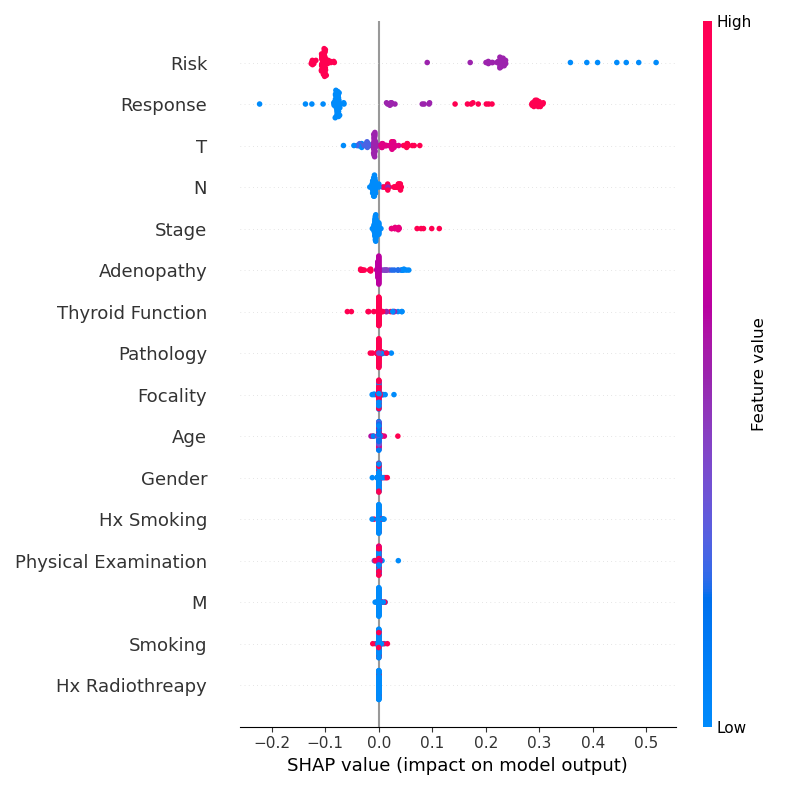

In [4]:
# Plot and save SHAP summary plot for positive class
# Create a figure with custom size
fig, ax = plt.subplots(figsize=(6, 4))  # Change width and height as needed
plt.sca(ax)
shap.summary_plot(shap_values[1], X_test_df, feature_names=feature_names, show=False)
# plt.title("A", loc="left", fontsize=16, fontweight="bold")
plt.savefig("../results/SHAP Summary Plot for Best Model.png", bbox_inches="tight")

<IPython.core.display.Javascript object>


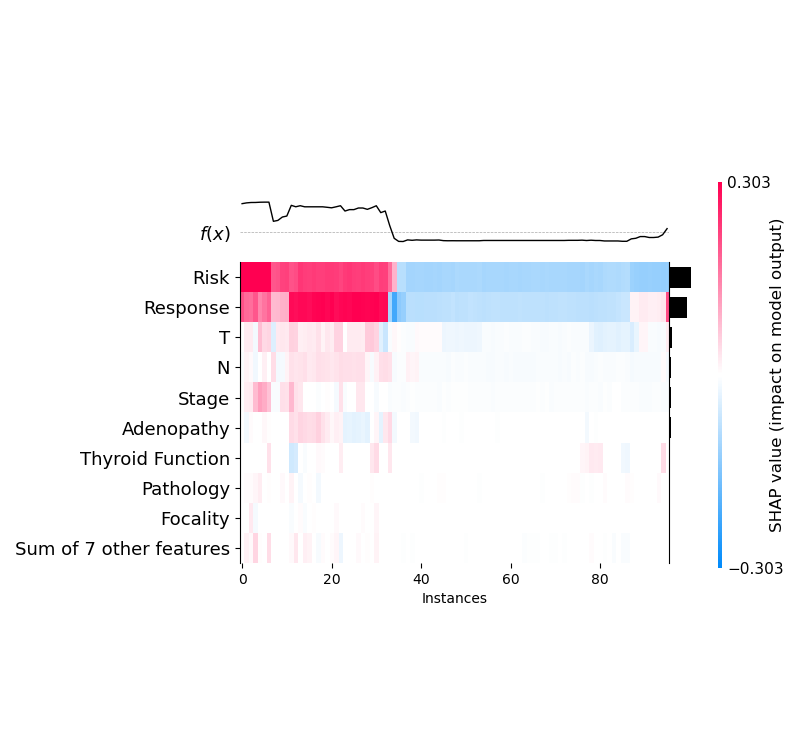

In [5]:
# Create a figure with custom size
fig, ax = plt.subplots(figsize=(3, 1))  # Change width and height as needed
plt.sca(ax)
shap.plots.heatmap(explanation, show=False)
# plt.title("B", loc="left", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("../results/SHAP Heatmap for Best Model.png", bbox_inches="tight")

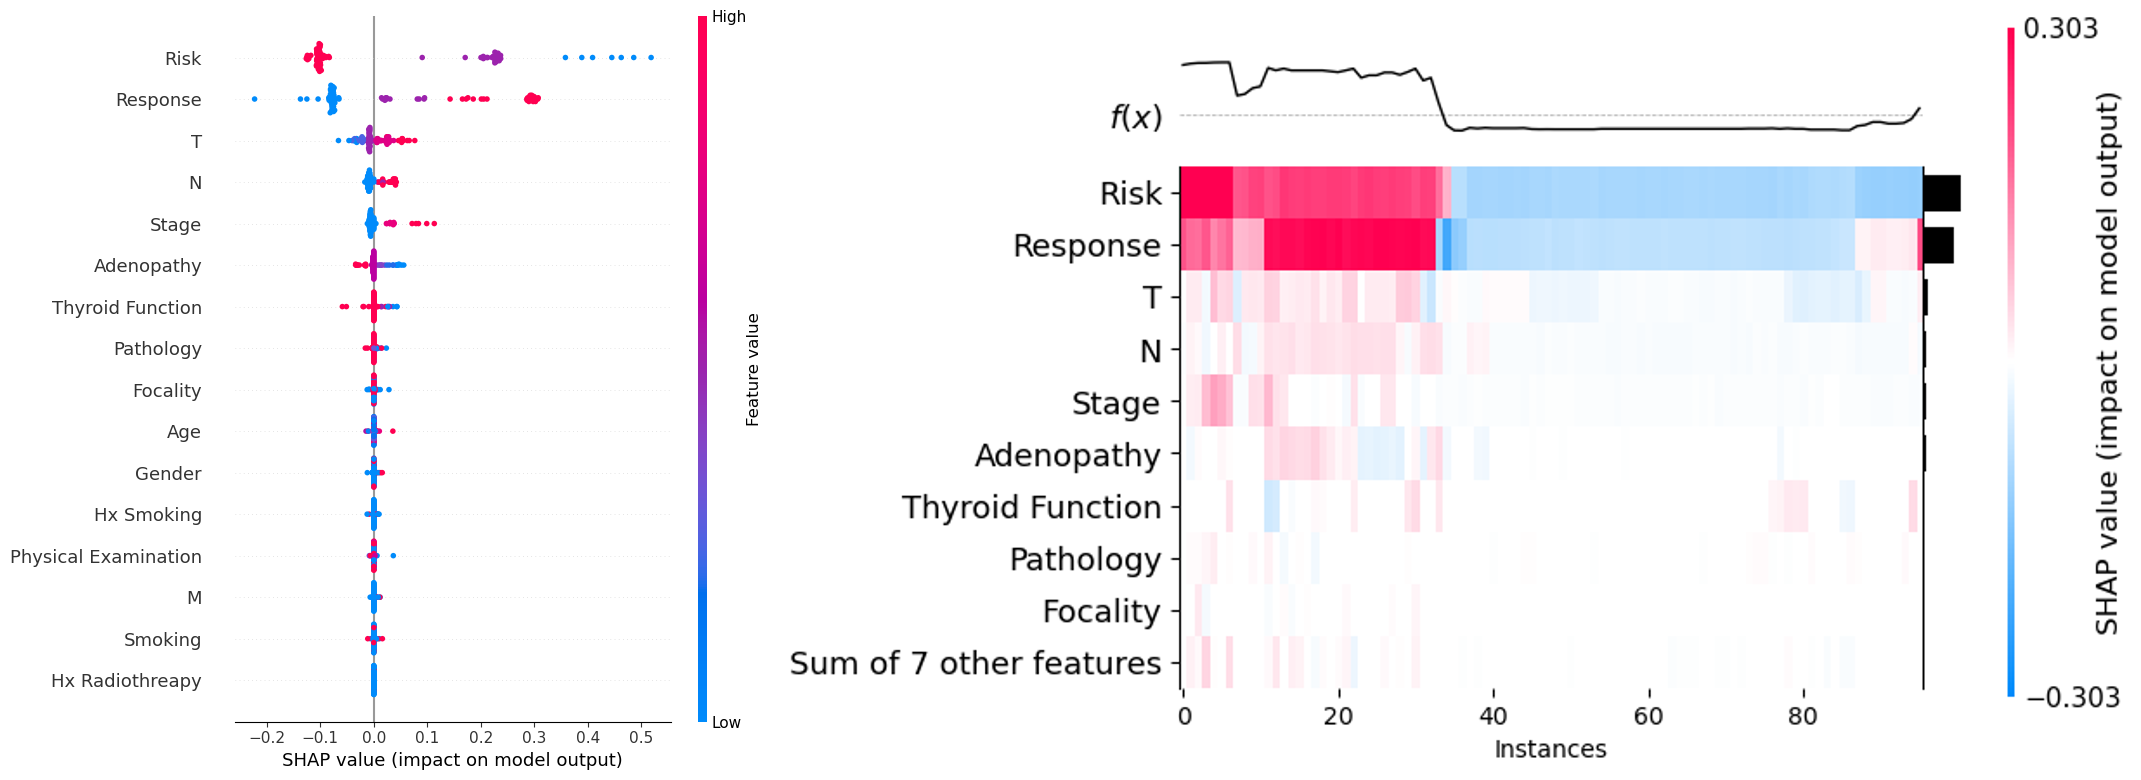

In [9]:
from PIL import Image

# Load images
img1 = Image.open("../results/SHAP Summary Plot for Best Model.png")
img2 = Image.open("../results/SHAP Heatmap for Best Model.png")

# Resize img2 to match height of img1 (preserve aspect ratio)
img2_ratio = img2.width / img2.height
new_width = int(img1.height * img2_ratio)
img2_resized = img2.resize((new_width, img1.height))

# Create a new blank image with combined width
combined = Image.new('RGB', (img1.width + img2_resized.width, img1.height))

# Paste both images side by side, aligned at the top
combined.paste(img1, (0, 0))
combined.paste(img2_resized, (img1.width, 0))

# Save and return
combined.save("../results/SHAP Summary and Heatmap Combined.png")
combined  # or just: display(combined) in a notebook

In [ ]:
# from PIL import Image

# # Load images
# img1 = Image.open("../results/SHAP Summary Plot for Best Model.png")
# img2 = Image.open("../results/SHAP Heatmap for Best Model.png")

# # Resize to same height if needed
# # img1 = img1.resize((img1.width, img1.height))
# # img2 = img2.resize((img1.width, img1.height))

# # Create a new blank image with combined width
# combined = Image.new('RGB', (img1.width + img2.width, img1.height))
# combined.paste(img1, (0, 0))
# combined.paste(img2, (img1.width, 0))

# # Save combined image
# combined.save("../results/SHAP Summary and Heatmap Combined.png")
# combined